# Dimension Reduction and Data Visualization

Today we'll see some tools you might use for visualizing data.

This falls under the umbrella of [Exploratory Data Analysis](https://en.wikipedia.org/wiki/Exploratory_data_analysis), which is often used to generate hypotheses.

Let's consider data sampled from a low-dimensional space with added noise

\begin{equation}
X_i \sim U(S^k) + N(0,\sigma^2)
\end{equation}

We'll refer to the data $\{X_i\}$ as a point cloud.  This means we're going to think of the samples as points in some space.  Any data set can be treated as a point cloud.  We'll represent this point cloud using an $n\times d$ numpy array, where $n$ is the number of samples, and $d$ is the dimension of the space.

One thing we would like to do is visualize our point cloud.


In [1]:
import numpy as np
import matplotlib.pyplot as plt

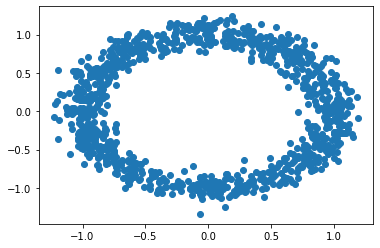

In [2]:
def sample_noisy_sphere(n, k=1, sigma=0.1):
    """
    Sample n points uniformly at random from the k-sphere
    embedded in k+1 dimensions
    
    Add normal nosie with variance sigma
    """
    d = k+1  # dimension of space

    X = np.random.randn(n,d)
    X = X / np.linalg.norm(X, axis=1).reshape(n,-1) # project onto sphere

    return X + sigma*np.random.randn(n,d)


X = sample_noisy_sphere(1000)

plt.scatter(X[:,0], X[:,1])
plt.show()

Above, we see a pretty clean circle.  But what if the circle is in three dimensions?

In [3]:
def sample_noisy_sphere(n, **kw):
    """
    Sample n points uniformly at random from the k-sphere
    embedded in d dimensions.
    
    Add normal nosie with variance sigma
    
    Arguments:
        n - number of samples
    
    Optional arguments:
        r - radius of circle (default 1.0)
        k - dimension of sphere (default k = 1 == circle)
        sigma - noise variance (default 0.1)
        d - dimension of embedded space (default k+1)
    """
    r = kw.get('r', 1.0)
    k = kw.get('k', 1)
    sigma = kw.get('sigma', 0.1)
    d = kw.get('d', k+1)

    X = np.random.randn(n,k+1)
    X = r * X / np.linalg.norm(X, axis=1).reshape(n,-1) # project onto sphere
    
    Q, R = np.linalg.qr(np.random.randn(d, k+1))
    X = X @ Q.T # apply random rotation

    return X + sigma*np.random.randn(n,d)

(note: taking the `Q` factor of the QR decomposition of a random normal matrix is a good way to sample random subspaces)

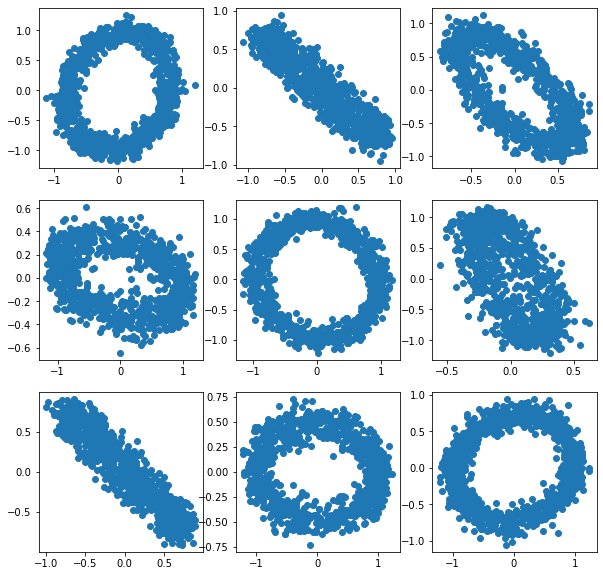

In [4]:
m, n = 3,3
fig, ax = plt.subplots(m,n, figsize=(10,10))
for i in range(m):
    for j in range(n):
        X = sample_noisy_sphere(1000, d=3)

        ax[i,j].scatter(X[:,0], X[:,1])
        
plt.show(fig)

It isn't always easy to see the circle in the scatter plot.  This is because if we choose two dimensions arbitrarily, we don't always align well with the rotated circle.

## Plotly

[Plotly](https://plotly.com/python/) is an open sourced graphing library which can help you create Javascript visualizations you can interact with in a web browser.

```bash
conda install plotly
conda install nbformat # you may need this
```

In [5]:
import plotly
import plotly.graph_objects as go

In [6]:
X = sample_noisy_sphere(1000, d=3)
fig = go.Figure(data=[go.Scatter3d(x=X[:,0], y=X[:,1], z=X[:,2],
                                   mode='markers')])
fig.show()

We'll define a function for quick 3D scatter plots

In [7]:
def quick_scatter(X):
    fig = go.Figure(data=[go.Scatter3d(x=X[:,0], y=X[:,1], z=X[:,2],
                                   mode='markers')])
    fig.show()

## Dimension Reduction

Dimension reduction is the process of taking a high-dimensional data set and embedding it in a lower dimension.

Often, data with many features is really generated by a process with only a handful of parameters.  This typically means we can think of data being sampled from a low-dimensional (parameter) space, but embedded in a high-dimensional feature space (perhaps with some noise).

Dimension reduction algorithms seek to reverse this process - we want to go from the high dimensional feature space to a lower dimensional space where the data generating mechanism may be easier to reason about.

### Principal Component Analysis (PCA)

The simplest way to reduce the dimension of real-valued data is through a linear projection.

In [8]:
X = sample_noisy_sphere(1000, d=100, sigma=0.01)
Q, R = np.linalg.qr(np.random.randn(X.shape[1], 3))
X2 = X @ Q
quick_scatter(X)

Clearly, a random projection isn't necessarily the most useful.  We want the **best possible** subspace to project onto.  PCA defines the best $d$-dimensional subspace as the $d$-dimensional subspace with the largest variance in the data.

Recall that we can calculate the population variance using
$$\hat{\Sigma} = \frac{1}{n}X^T X$$
Where we assume $X$ has zero mean (i.e $\tfrac{1}{n} 1^T X = 0$)

Let $v$ be a unit vector.  The projection onto the subspace spanned by $v$ is calculated as $X v$.  Note that if $X$ has zero-mean that $Xv$ will also have zero mean (prove it).  The variance in this 1-dimensional subspace is then
$$\sigma(v) = \frac{1}{n} (Xv)^T (Xv) = \frac{1}{n} v^T X^T X v$$

So the subspace with the largest variance is defined by the unit vector $v$ which maximizes
$$v^T (\frac{1}{n} X^T X) v = v^T \hat{\Sigma} v$$

We can write this as the variational problem
$$ 
\operatorname{maximze}_{v\in \mathbb{R}^n} v^T \hat{\Sigma} v\\
\text{subject to } \|v\|_2 = 1
$$

We recognize this as the problem of [finding the largest magnitude eigenpair](https://en.wikipedia.org/wiki/Min-max_theorem) of $\hat{\Sigma}$, where $v$ is the eigenvector, and the eigenvalue of $v$ is $\sigma(v)$ (prove it).

If we want to project into a $k+1$ dimensional space, we then find 
$$ 
\operatorname{maximze}_{v\in \mathbb{R}^n} v^T \hat{\Sigma} v\\
\text{subject to } \|v\|_2 = 1, v^T V_k = 0
$$
where $V_k = [v_1,\dots,v_k]$ spans the optimal $k$-dimensional subspace.

This boils down to finding the largest $k+1$ dimensional eigenspace of $\hat{\Sigma}$.

The vectors $v_1,\dots, v_k$ are known as the **principal components** of $X$

In [9]:
def mean_center(X):
    mu = np.average(X, axis=0) # 1^T X / n
    return X - mu

def variance(X):
    n = X.shape[0]
    X = mean_center(X)
    return X.T @ X / n

def principal_vectors(X, k=3):
    Sigma = variance(X)
    lam, V = np.linalg.eigh(Sigma)
    return V[:,-k:] # eigenvalues in increasing order

def pca_projection(X, k=3):
    V = principal_vectors(X, k=k)
    return X @ V


X = sample_noisy_sphere(1000, d=100, sigma=0.1)
Xpca = pca_projection(X, k=3)

quick_scatter(Xpca)

#### PCA Via the SVD

In practice, you **should not** compute PCA by forming $X^T X$.  Why?  Because if $X$ is ill-conditioned, then $X^T X$ will be even more ill conditioned.

What you should do is use the SVD of $X$.  If $X = U \Sigma V^T$ then 
$$X^T X = V \Sigma^T U^T U \Sigma V^T = V \Sigma^2 V^T$$
Clearly, the right-singular vectors $V$ are the eigenvectors of $X^T X$.

#### Exercises

1. Write a function to project a design matrix `X` onto its top `k` principal components using the SVD.
2. Modify your function to use ARPACK via `scipy.sparse.linalg.svds`
3. What is the condition number $\kappa(X^T X)$ expressed in terms of $\kappa(X)$? 
<span style="text-decoration:underline" title="Use the SVD">(Hint)</span>
4. Plot the singular values of `X` generated above - how might you decide how many principal components to use?

In [10]:
# Your code here


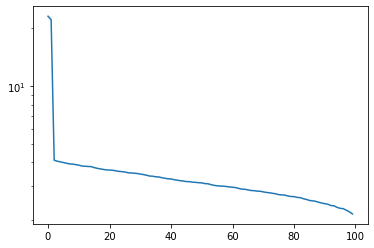

In [11]:
X = sample_noisy_sphere(1000, d=100, sigma=0.1)
u, s, v = np.linalg.svd(X)
plt.semilogy(s)

## Nonlinear Dimensionality Reduction

Often linear projections are not sufficient to visualize structure in data because an embedding into parameter space is not linear.  There are a variety of techniques you can use for [nonlinear dimensionality reduction](https://en.wikipedia.org/wiki/Nonlinear_dimensionality_reduction).

These techniques often fall under the umbrella of "manifold learning" because we think if the parameter space describing the data as some manifold.

We'll use [Scikit-Learn's manifold learning module](https://scikit-learn.org/stable/modules/manifold.html) to explore these algorithms.

```bash
conda install scikit-learn
```

### Scikit-learn Syntax

Let's go over how Scikit-Learn operates.  We'll use PCA as an example.  See [the documentation](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html).

In general, Scikit-Learn provides objects that will perform some algorithm on data.  In this case, we'll use a `PCA` object.

In [15]:
from sklearn.decomposition import PCA

In [16]:
transformer = PCA(n_components=3)
type(transformer)

sklearn.decomposition._pca.PCA

There are two stages to using a dimension reduction technique.  

First we "fit" an object (`transformer` above), to the data.  Then we can transform `X` using the object.

In [17]:
X = sample_noisy_sphere(1000, d=100, sigma=0.01)
transformer.fit(X)
Xpca = transformer.transform(X)

quick_scatter(Xpca)

You can also use the combined `fit_transform` method

In [19]:
Xpca = transformer.fit_transform(X)
quick_scatter(Xpca)


array([[-0.65229446, -0.68268028, -0.0083113 ],
       [ 0.97693249,  0.32827913,  0.01692099],
       [-0.96586653,  0.09123556,  0.00993592],
       ...,
       [ 0.18539985,  1.01839156,  0.01804215],
       [-0.155945  , -0.94727308,  0.0035343 ],
       [ 0.59564203,  0.84754365, -0.01103846]])

### Generating Nonlinear Data

Let's make our data more interesting.  First, we'll generate some nested circles

In [20]:
def nested_spheres(*rs, **kw):
    """
    generate nested circles
    
    Arguments:
        r1, r2, r3,... radii of circles
        
    Optional arguments:
        n = number of samples for each circle (default 500)
        additional arguments will be passed to sample_noisy_sphere
    """
    ns = kw.pop('n', 500) # remove key from dict
    if type(ns) is int:
        ns = tuple(ns for r in rs)
      
    data = []
    for n, r in zip(ns, rs):
        data.append(sample_noisy_sphere(n, r=r, **kw))
        
    return np.concatenate(data, axis=0)


X = nested_spheres(1.0, 2.0, 3.0, d=3)
quick_scatter(X)

We can also apply a non-linear function to the data

In [40]:
def f(x):
    y = [x[0]*x[1], x[0] - x[1], np.sin(x[1]), np.cos(x[1])]
    y.extend([x[i] for i in range(2, len(x))])
    return np.array(y)

Y = np.array([f(x) for x in X])
quick_scatter(Y)

We can see PCA is a bit convoluted:

In [26]:
Ypca = PCA().fit_transform(Y)
quick_scatter(Ypca)

### Kernel PCA

[Documentation](https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.KernelPCA.html)

In [27]:
from sklearn.decomposition import KernelPCA
transformer = KernelPCA(n_components=3, kernel="rbf")
Ytrans = transformer.fit_transform(Y)
quick_scatter(Ytrans)

### Isomap

In [28]:
import sklearn.manifold as manifold

In [29]:
transformer = manifold.Isomap(n_components=3)
Ytrans = transformer.fit_transform(Y)
quick_scatter(Ytrans)

/opt/anaconda3/envs/pycourse/lib/python3.8/site-packages/sklearn/manifold/_isomap.py:322: UserWarning:

The number of connected components of the neighbors graph is 5 > 1. Completing the graph to fit Isomap might be slow. Increase the number of neighbors to avoid this issue.

/opt/anaconda3/envs/pycourse/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning:

Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.

/opt/anaconda3/envs/pycourse/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning:

Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.

/opt/anaconda3/envs/pycourse/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning:

Changing the sparsity structure of a csr_matrix is expensive. lil_matrix is more efficient.

/opt/anaconda3/envs/pycourse/lib/python3.8/site-packages/scipy/sparse/_index.py:82: SparseEfficiencyWarning:

Chan

### Spectral Embedding

Spectral embeddings are computed from a graph obtained from the data.  Typically, a weighted nearest neighbors graph.

In [30]:
transformer = manifold.SpectralEmbedding(n_components=3)
Ytrans = transformer.fit_transform(Y)
quick_scatter(Ytrans)

### t-SNE

In [32]:
transformer = manifold.TSNE(n_components=3, init='pca', random_state=0)
Ytrans = transformer.fit_transform(Y)
quick_scatter(Ytrans)

/opt/anaconda3/envs/pycourse/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:790: FutureWarning:

The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.

/opt/anaconda3/envs/pycourse/lib/python3.8/site-packages/sklearn/manifold/_t_sne.py:982: FutureWarning:

The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.



### Multidimensional Scaling

Let's use a metric rather than the standard Euclidean metric

In [36]:
from scipy.spatial.distance import pdist, squareform # pairwise distances
D = squareform(pdist(Y, 'cityblock')) # L1 metric

In [37]:
transformer = manifold.MDS(n_components=3, dissimilarity="precomputed")
Ytrans = transformer.fit_transform(D)
quick_scatter(Ytrans)

KeyboardInterrupt: 